# Practice PS07: Outlier analysis

The objective of this session is to practice finding outliers by implementing the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Your name here</font>

E-mail: <font color="blue">Your e-mail here</font>

Date: <font color="blue">The current date here</font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

We will use the file `annthyroid.csv` that contains data about exams of the thyroid gland of 7,200 patients. In each exam, six attributes *f1*, *f2*, ..., *f6* of each patient are measured. A ground-truth label indicating if the thyroid was finally found to be normal or abnormal is included in the dataset. Further information on this dataset can be found in this [free repository](http://odds.cs.stonybrook.edu/annthyroid-dataset/).

Leave the loading code below as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
# LEAVE AS-IS

df = pd.read_csv('annthyroid.csv', sep=',')

# Replace the "label" column by an "abnormal" column
df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

Print the total number of patients, the number and percentage of patients with a normal thyroid, and the number and percentage of patients with an abnormal thyroid.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the number and percentages of patients in each group.</font>

Print the first 10 normal exams, and the "centroid" (average) of a normal exam.

Print the first 10 abnormal exams, and the "centroid" (average) of a normal exam.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the 10 normal exams and their centroid, and the first 10 abnormal exams and their centroid.</font>

<font size="+1" color="red">Replace this cell with a brief comment indicating, based only on the means, which features do you think could be useful for differentiating between normal and abnormal thyroids? Why?</font>

Note that identifying outliers in this dataset is possible because outliers seem to be quite different, across many dimensions, from inliers. To show this, we can create all scatter plots of combinations of two dimensions in the data. In these, you can see that feature values for the minority class (represented by the color red), indeed are quite different from feature values for the majority class (represented by the color blue).

Use [scatter_matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) to create a matrix of scatter plots. The following code creates a simple scatter matrix. Pick color1 and color2 from the list of [matplotlib colors](https://matplotlib.org/stable/gallery/color/named_colors.html).

```python
color_code = {'abnormal': ..., 'normal': ...}

colors = df['result'].apply(lambda x: color_code[x])

pd.plotting.scatter_matrix(df, c=colors)
```

Change the figure size with parameter `figsize`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to create a scatter matrix as described above.</font>

<font size="+1" color="red">Replace this cell with a brief commentary on whether you already guess any difference between normal and abnormal exams, based on combinations of features. What are the differences you can appreciate?</font>

# 1. Create isolation tree

## 1.1. Random dimension and random split

Create a function that returns a random dimension in the dataset. We will ignore some columns, because the random dimension can never be *id* or *result*, but instead should be one of the other dimensions 'f1', 'f2', ..., 'f6'. Do not hard-code these dimensions into your function, instead, read df.columns.

The signature of your function should be `pick_random_dimension(df, columns_to_ignore)`.

Test your function by calling it a few times. It should return a random dimension every time, among the columns of the dataset, excluding the *columns_to_ignore*.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code implementing "pick_random_dimension" and a couple of calls to this function.</font>

Create a function that returns a random split point along a dimension. Do not rely on the fact that, *on this dataset* every dimension takes a value between 0.0 and 1.0. Instead, use `np.min(df[dimension])` and `np.max(df[dimension])`.

The signature of your function should be `pick_random_split(df, dimension)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code implementing "pick_random_split" and a couple of calls to test this function; each call should return a random split point chosen uniformly at random between the minimum and the maximum value along a dimension.</font>

## 1.2. Implement split data into two

Implement a function `split_dataset(df, dimension, split)` that returns two sub-datasets: one with all elements having *dimension <= split*, and another one with all elements having *dimension > split*.

The signature of your function should be `split_dataset(df, dimension, split)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code implementing "split_dataset".</font>

Remember to test your function; for instance, split on dimension `f1` at `0.5` by doing:

```python
(left, right) = split_dataset(df, 'f1', 0.5)
```

In the output, all the rows in *left* have *f1 <= 0.5* and all the rows in *right* have *f1 > 0.5*.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code testing "split_dataset", i.e., select a dimension and a cut-off and split the dataset, then print the two pieces and check that it is working correctly.</font>

## 1.3. Create one isolation tree

First, let us add a patient identifier in column "id". The new dataframe is called `dfi`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [10]:
# LEAVE AS-IS

dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


An isolation tree will be a dictionary. In this dictionary, having *contents*, indicates an external node of the tree, while having *left* and *right* indicates an internal node of the tree.

Create a recursive function `isolation_tree(data, columns_to_ignore, min_items)` that:

* If the *data* has *min_items* or less:
    * Return a dictionary `{"contents": data}`
* If the *data* has more than *min_items*
    * Selects a random dimension from the data, ignoring the *columns_to_ignore*
    * Selects a random split point along that dimension
    * Sets `left` to an isolation tree containing points having dimension <= split
    * Sets `right` to an isolation tree containing points having dimension > split
    * Returns a dictionary `{"left": left, "right": right, "dimension": dimension, "split": split}`

You can use the following skeleton:

```python
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        # REPLACE WITH YOUR CODE 
        return tree   
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with you code implementing "isolation_tree".</font>

Test your function creating a shallow tree.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [12]:
# LEAVE AS-IS

mytree = isolation_tree(dfi, ['id', 'result'], 2000)

You do not need to modify the next function, which is useful to print a tree in ASCII.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [13]:
# LEAVE AS-IS

class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

Print your tree using this function. It should look something like this:

```
:'internal node: f4 <= 0.30'
-<:'internal node: f3 <= 0.03'
--<:'internal node: f5 <= 0.07'
---<:'external node: 226 normal + 16 abnormal'
--->:'internal node: f6 <= 0.12'
----<:'external node: 4215 normal + 473 abnormal'
---->:'external node: 1641 normal + 34 abnormal'
-->:'external node: 576 normal + 11 abnormal'
->:'external node: 8 normal + 0 abnormal'
```

Given that the tree is created by a **randomized process**, your tree will be different.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [14]:
print(tree_to_nodes(mytree))

:'internal node: f2 <= 0.19'
-<:'internal node: f3 <= 0.07'
--<:'internal node: f3 <= 0.04'
---<:'internal node: f4 <= 0.17'
----<:'internal node: f1 <= 0.13'
-----<:'external node: 53 normal + 8 abnormal'
----->:'internal node: f6 <= 0.14'
------<:'internal node: f1 <= 0.26'
-------<:'external node: 584 normal + 33 abnormal'
------->:'internal node: f1 <= 0.96'
--------<:'internal node: f6 <= 0.09'
---------<:'external node: 988 normal + 287 abnormal'
--------->:'internal node: f5 <= 0.03'
----------<:'external node: 1 normal + 0 abnormal'
---------->:'internal node: f1 <= 0.83'
-----------<:'internal node: f6 <= 0.13'
------------<:'internal node: f1 <= 0.37'
-------------<:'external node: 484 normal + 18 abnormal'
------------->:'internal node: f1 <= 0.78'
--------------<:'internal node: f3 <= 0.03'
---------------<:'internal node: f2 <= 0.00'
----------------<:'external node: 278 normal + 0 abnormal'
---------------->:'internal node: f5 <= 0.10'
-----------------<:'external node: 1

Create a function `get_max_tree_depth` that returns the maximum depth of a tree.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with you code implementing `get_max_tree_depth`</font>

<font size="+1" color="red">Replace this cell with you code testing `get_max_tree_depth` on `mytree`.</font>

# 2. Create isolation forests and find depth of items

An isolation forest will be simply a an array of isolation trees.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 2.1. Create an isolation forest

Write a function `isolation_forest(dfi, columns_to_ignore, min_items, num_trees)` that creates an array of *num_trees* isolation trees.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with you code implementing "isolation_tree".</font>

Use the next code to test how to create an isolation forest of 20 trees, in which leaves have at least 50 items. It might take a few minutes to run.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Use the next code to test how to create an isolation forest of 30 trees, in which leaves have at least 100 items. It might take a few minutes to run.

**Note: please feel free to experiment with different number of trees and different number of minimum items.** If when performing the rest of the experiments and the histograms below, you notice that a different set of parameters yields more separation between classes, modify the next cell. If you do, please indicate clearly that you changed these parameters.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [19]:
# MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES

min_items = 50
num_trees = 20

In [20]:
# LEAVE AS-IS

myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 20 trees


Now we print the first two trees of this forest.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [21]:
# Leave this code as-is

for i in range(0, 2):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f5 <= 0.05'
-<:'external node: 29 normal + 0 abnormal'
->:'internal node: f1 <= 0.04'
--<:'external node: 16 normal + 7 abnormal'
-->:'internal node: f5 <= 0.15'
---<:'internal node: f2 <= 0.44'
----<:'internal node: f2 <= 0.28'
-----<:'internal node: f5 <= 0.07'
------<:'internal node: f3 <= 0.08'
-------<:'internal node: f4 <= 0.13'
--------<:'internal node: f3 <= 0.01'
---------<:'internal node: f3 <= 0.01'
----------<:'external node: 30 normal + 5 abnormal'
---------->:'external node: 22 normal + 4 abnormal'
--------->:'internal node: f3 <= 0.03'
----------<:'internal node: f2 <= 0.00'
-----------<:'internal node: f3 <= 0.01'
------------<:'external node: 5 normal + 0 abnormal'
------------>:'internal node: f6 <= 0.17'
-------------<:'external node: 48 normal + 0 abnormal'
------------->:'external node: 9 normal + 0 abnormal'
----------->:'external node: 32 normal + 3 abnormal'
---------->:'external node: 1 normal + 0 abnormal'
-------->:'external nod

## 2.2. Find the average depth of an item

Thie function `find_element_depth` finds the depth of a given element by recursively traversing the tree. It is a complicated function so we provide it. You can leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [22]:
# LEAVE AS-IS

def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

Test this function by running it to find 5 normal and 5 abnormal thyroid exams on the shallow tree `mytree` that we created above, and on the first tree of the forest we created.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [23]:
# LEAVE AS-IS

def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))
            
    
print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print("On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0]))
print_sample_depths(dfi, 5, myforest[0])
print()


On shallow tree, having maximum depth 17
Depths for normal items
- id=P4892 is at depth 17/17
- id=P4305 is at depth 17/17
- id=P6559 is at depth 17/17
- id=P6356 is at depth 17/17
- id=P5265 is at depth 9/17
Depths for abnormal items
- id=P6891 is at depth 9/17
- id=P2042 is at depth 9/17
- id=P2813 is at depth 17/17
- id=P2632 is at depth 9/17
- id=P3597 is at depth 9/17

On first tree of forest, having maximum depth 34
Depths for normal items
- id=P2785 is at depth 11/34
- id=P6108 is at depth 28/34
- id=P2940 is at depth 17/34
- id=P3690 is at depth 17/34
- id=P7116 is at depth 15/34
Depths for abnormal items
- id=P0117 is at depth 13/34
- id=P0209 is at depth 16/34
- id=P3275 is at depth 14/34
- id=P6284 is at depth 30/34
- id=P2642 is at depth 21/34



<font size="+1" color="red">Replace this cell with a brief commentary on these depths.</font>

Write function `find_average_depth(forest, column_name, value)` that finds the the average depth of an element having *column_name = value*

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


<font size="+1" color="red">Replace this cell with you code implementing "find_average_depth".</font>

Test this function with five random elements.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [25]:
# LEAVE AS-IS

for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)
    
    sample = list(dfi[dfi['result'] == result]['id'].sample(5))
    
    for random_id in sample:
        print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))
    
    print()

Average depths for normal items
- id=P0808 is at average depth 18.1
- id=P4735 is at average depth 22.7
- id=P5823 is at average depth 23.0
- id=P4977 is at average depth 17.6
- id=P2755 is at average depth 16.7

Average depths for abnormal items
- id=P1276 is at average depth 9.8
- id=P1943 is at average depth 14.5
- id=P6039 is at average depth 14.2
- id=P2262 is at average depth 17.2
- id=P4943 is at average depth 17.2



<font size="+1" color="red">Replace this cell with a brief commentary indicating how would you make the "find_average_depth" function more efficient if you wanted to obtain the average depth of **all** elements. Be concise but be precise, providing pseudocode if you consider it clearer than a text explanation.</font>

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

Next we sample 30 normal and 30 abnormal points, and store their average depths in `myforest` into arrays `normal_depths` and `abnormal_depths`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [28]:
# LEAVE AS-IS

abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(30))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(30))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P1860', 'P4714', 'P5011', 'P2977', 'P5192', 'P3228', 'P3711', 'P3528', 'P3265', 'P7180', 'P1030', 'P1931', 'P4230', 'P6964', 'P1251', 'P4092', 'P2122', 'P1287', 'P4058', 'P5208', 'P0128', 'P1343', 'P1261', 'P6072', 'P4705', 'P4246', 'P1193', 'P5174', 'P2429', 'P2866']
Abnormal point sample ids : ['P4613', 'P5212', 'P0568', 'P0795', 'P6290', 'P3305', 'P4328', 'P1463', 'P6912', 'P4738', 'P6973', 'P0344', 'P7077', 'P2157', 'P2453', 'P4968', 'P5926', 'P2554', 'P5308', 'P4514', 'P6382', 'P1470', 'P4480', 'P6769', 'P1337', 'P1189', 'P2005', 'P5482', 'P1109', 'P0609']


In [29]:
# LEAVE AS-IS

normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P1860 is at average depth 22.00
 element id=P4714 is at average depth 16.75
 element id=P5011 is at average depth 24.40
 element id=P2977 is at average depth 21.65
 element id=P5192 is at average depth 23.75
 element id=P3228 is at average depth 22.60
 element id=P3711 is at average depth 22.95
 element id=P3528 is at average depth 23.20
 element id=P3265 is at average depth 19.40
 element id=P7180 is at average depth 20.60
 element id=P1030 is at average depth 20.30
 element id=P1931 is at average depth 16.75
 element id=P4230 is at average depth 27.35
 element id=P6964 is at average depth 17.60
 element id=P1251 is at average depth 22.10
 element id=P4092 is at average depth 18.10
 element id=P2122 is at average depth 19.55
 element id=P1287 is at average depth 24.20
 element id=P4058 is at average depth 17.75
 element id=P5208 is at average depth 16.10
 element id=P0128 is at average depth 16.50
 element id=P1343 is at average dept

In [30]:
# LEAVE AS-IS

abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P4613 is at average depth 10.55
 element id=P5212 is at average depth 16.70
 element id=P0568 is at average depth 15.00
 element id=P0795 is at average depth 11.45
 element id=P6290 is at average depth 19.25
 element id=P3305 is at average depth 16.40
 element id=P4328 is at average depth 17.05
 element id=P1463 is at average depth 18.65
 element id=P6912 is at average depth 14.70
 element id=P4738 is at average depth 18.15
 element id=P6973 is at average depth 8.85
 element id=P0344 is at average depth 16.55
 element id=P7077 is at average depth 21.65
 element id=P2157 is at average depth 18.30
 element id=P2453 is at average depth 17.75
 element id=P4968 is at average depth 21.90
 element id=P5926 is at average depth 13.65
 element id=P2554 is at average depth 18.45
 element id=P5308 is at average depth 21.05
 element id=P4514 is at average depth 8.10
 element id=P6382 is at average depth 9.00
 element id=P1470 is at average depth

Now, we create an histogram of the depths of normal and abnormal items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

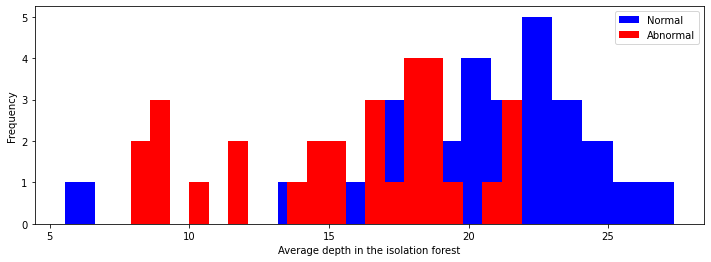

In [31]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in this histogram.</font>

## 3.2. Compute outlier scores and conclude

Use this fast method to compute harmonic numbers. Leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [32]:
# LEAVE AS-IS

# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

With this and the formula seen in class, you can compute outlier scores. The function below, which you should leave as-is, uses the *factory* design pattern to avoid computing *c(n)* every time the outlier score needs to be computed.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [33]:
# LEAVE AS-IS

def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

Finally, we plot an histogram of outlier scores of normal and abnormal items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

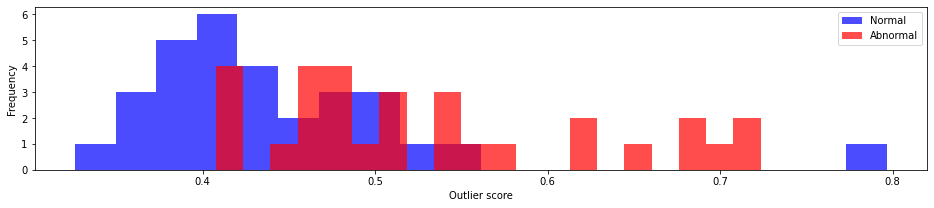

In [34]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in this histogram.</font>

Next, write code to determine an optimal outlier score threshold based on `normal_scores` and `abnormal_scores` assuming every thyroid exam having *score <= threshold* will be classified as normal, and every thyroid exam with score > threshold will be classified as abnormal.

You can do binary search, linear search, random search, etc.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to determine an optimal threshold.</font>

Evaluate the threshold you have found. We know results will not be perfect as in this dataset there are some normal exams that look like abnormal and viceversa. If you use this threshold, indicate what is the estimated **false positive rate** (the probability of saying that a thyroid is abnormal when it is normal), and **false negative rate** (the probability of saying that a thyroid is normal when it is abnormal).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your evaluation of the optimal threshold.</font>

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, implement a faster method for finding_average_depths, indicating in your report that you implemented a faster method. Then, in the histograms do not sample but instead use all the elements in the dataset, i.e., remove `.sample(...)`.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: faster method to find all depths</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>